# Exploratory data analaysis for IPC data

## Set export to True if you wish to export graphs and tables


In [13]:
export = False
seed = 1337


In [ ]:
from os import system
from sys import modules

IN_COLAB = 'google.colab' in modules
if True:
    system('git clone https://github.com/ICascha/Predicting-food-crises-in-Somalia')
    system('pip install geopandas')
    %cd Predicting-food-crises-in-Somalia/notebooks

In [2]:
from sklearn.cluster import KMeans
import warnings
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from os import listdir
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from auxiliary_code.helper_functions import *
from auxiliary_code.Clustering import Clustering
%matplotlib inline

warnings.simplefilter('ignore')


In [3]:
df_phase_fews_net = pd.read_csv(
    '../datasets/fews_net_ipc.csv', parse_dates=['date'])
set_index(df_phase_fews_net)

df_ipc = pd.read_csv('../datasets/ipc_processed.csv',
                     parse_dates=['date'], usecols=['date', 'area', 'area_phase'])
set_index(df_ipc)

df_phase = pd.concat([df_ipc, df_phase_fews_net])

df_hum = pd.read_csv(
    '../Datasets/humantarian_assistance.csv', parse_dates=['date'])
set_index(df_hum)

df_pop = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'], usecols=['date', 'area', 'pop'])
set_index(df_pop)

df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')


<AxesSubplot:xlabel='date'>

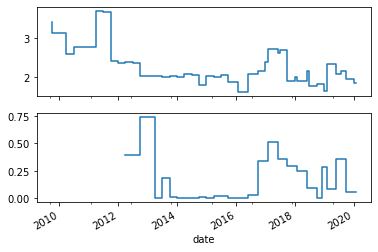

In [4]:
fig, ax = plt.subplots(nrows=2, sharex=True)


df_plot_phase = df_phase.merge(df_pop, left_index=True,
                               right_index=True)

df_plot_hum = df_hum.merge(df_pop, left_index=True,
                           right_index=True)

target = df_plot_phase['area_phase'].unstack()
weights = df_plot_phase['pop'].unstack()
norm_weights = weights / weights.sum()
(target * norm_weights).sum().plot(drawstyle='steps-pre', ax=ax[0])

target = df_plot_hum['hum_assistance'].unstack()
weights = df_plot_hum['pop'].unstack()
norm_weights = weights / weights.sum()
(target * norm_weights).sum().plot(drawstyle='steps-pre', ax=ax[1])


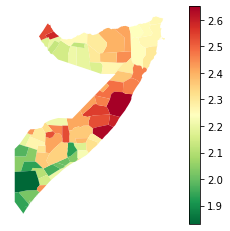

In [5]:
fig, ax = plt.subplots()

df_mean_phase_area = df_phase.groupby('area')['area_phase'].mean()
df_plot_phase = df_shape.merge(
    df_mean_phase_area, left_index=True, right_index=True)
df_plot_phase.plot(column='area_phase', cmap='RdYlGn_r', legend=True, ax=ax)
ax.axis('off')

if export:
    fig.savefig('../Figures/mean_phase_per_area.png',
                dpi=300, bbox_inches='tight')


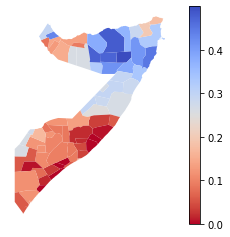

In [6]:
fig, ax = plt.subplots()

df_mean_phase_area = df_hum.groupby('area')['hum_assistance'].mean()
df_plot_phase = df_shape.merge(
    df_mean_phase_area, left_index=True, right_index=True)
df_plot_phase.plot(column='hum_assistance',
                   cmap='coolwarm_r', legend=True, ax=ax)
ax.axis('off')

if export:
    fig.savefig('../Figures/mean_hum_per_area.png',
                dpi=300, bbox_inches='tight')


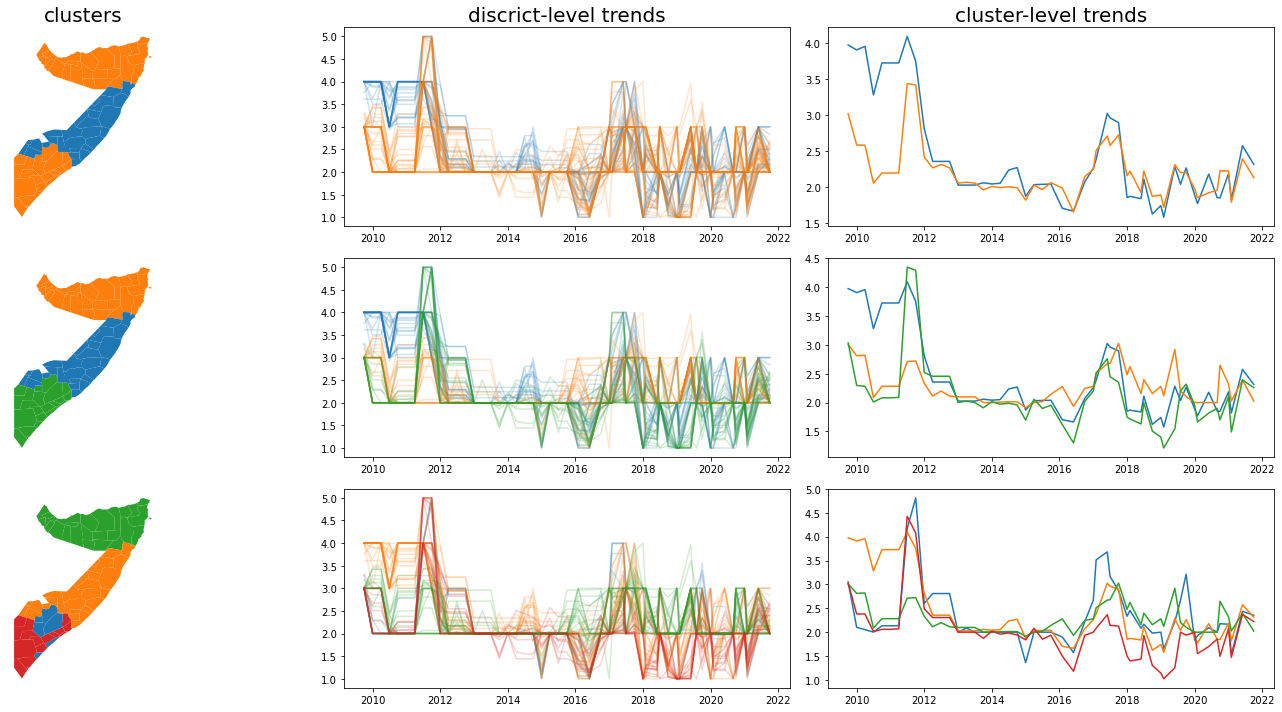

In [7]:
df_phase_unstacked = df_phase.unstack()
mask = df_phase_unstacked.isna().sum(axis=1) == 0
df_phase_unstacked = df_phase_unstacked[mask]
dates = df_phase_unstacked.columns.get_level_values(1)
areas = df_phase_unstacked.index
values = df_phase_unstacked.to_numpy()

clustering = Clustering(range(2, 5), seed)
fig = clustering.spatial_clustering(areas, values, dates, df_shape)

plt.tight_layout()

if export:
    plt.savefig('../Figures/clustering.png', dpi=300)


In [8]:
def transition_prob_matrix(phases_old, phases_new):
    fig, ax = plt.subplots()
    old_new = phases_old.merge(phases_new, left_index=True,
                               right_index=True).dropna().to_numpy()

    A = np.zeros((5, 5))
    for i, j in np.round(old_new).astype('int8'):
        A[i - 1, j - 1] += 1

    sns.heatmap(A / A.sum(axis=1).reshape(5, -1),
                annot=True, ax=ax, vmin=0, vmax=0.81)

    ax.set_xticklabels(range(1, 6))
    ax.set_yticklabels(range(1, 6))
    ax.set_xlabel('new phase')
    ax.set_ylabel('old phase')

    return fig


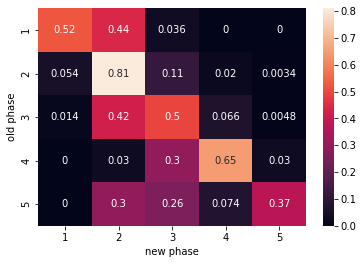

In [9]:
phases_old = df_phase_fews_net.sort_index()[['area_phase']]
phases_new = df_phase_fews_net.sort_index()['area_phase'].shift(-1)
fig = transition_prob_matrix(phases_old, phases_new)

if export:
    fig.savefig('../Figures/phase_transition_matrix_lag_1.png', dpi=300)


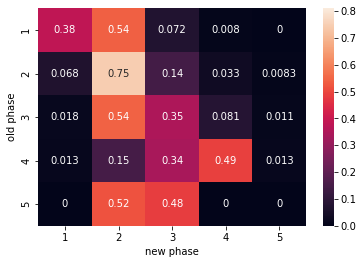

In [10]:
phases_new = df_phase_fews_net.sort_index()['area_phase'].shift(-2)
fig = transition_prob_matrix(phases_old, phases_new)
if export:
    fig.savefig('../Figures/phase_transition_matrix_lag_2.png', dpi=300)


In [11]:
counts = np.unique(
    ((df_phase['area_phase']).round().astype(int)), return_counts=True)
df_table = pd.DataFrame(
    {'phase': counts[0], 'frequency': counts[1]/counts[1].sum() * 100})
df_table['frequency'] = df_table['frequency'].round(1).astype(str) + ' %'
df_table.set_index('phase', inplace=True)

if export:
    print(df_table.to_latex())

df_table


,frequency
phase,
1,8.1 %
2,65.2 %
3,19.7 %
4,6.3 %
5,0.7 %


In [12]:
df_tab = df_phase.merge(df_pop, left_index=True,
                        right_index=True).copy()
df_tab['area_phase'] = df_tab['area_phase'].round().astype(int)

table = pd.DataFrame({'frequency': np.zeros(5)},
                     index=pd.Series(np.arange(1, 6), name='phase'))

for idx, row in df_tab.iterrows():
    table.loc[row['area_phase']] += row['pop']

table = round(table/table.sum() * 100, 1).astype('str') + ' %'

if export:
    print(table.to_latex())

table


,frequency
phase,
1,8.6 %
2,65.8 %
3,17.8 %
4,6.9 %
5,0.8 %
